# **APPLICATION OF CLUSTERING METHODS TO SPORULATION YEAST MICROARRAY DATA AGENDA**

## Lab 1 - Clustering (HC and SOM) applied to sporulation yeast data

**Author**: Diego De Pablo  
**Date**: October 2024

---

### **Introduction**

In this notebook, we will work on applying clustering methods to the sporulation yeast microarray data. The process will involve:

1. Initialize the libraries.
2. Reading the yeast data.
3. Preprocessing and preparing the data for clustering.
4. Visualizing Gene Expression Data with Seaborn
5. Applying hierarchical clustering (HC) and self-organizing maps (SOM).
6. Visualizing and analyzing the results obtained through various plots.

The main goal is to group genes into clusters that might reflect different stages of the sporulation process in yeast, allowing us to gain biological insights.

### **Initialize the libraries**
As usual in Python, we work with various libraries. As usual, all libraries will be initialized from the beginning, making it easier to execute third-party code by knowing which libraries will need to be installed to run the script.

In [30]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt

### **Reading the yeast data.**

In this step, we will load the dataset using pandas and check the basic structure of the data, including the number of rows (samples) and columns (variables).

The dataset is available in my github repository along with 5 study materials ([you can enter my repository by clicking here ](https://github.com/Diegodepab/clustering_genes/tree/main/dataset))


In [31]:
data = pd.read_csv('/content/sporulation-filtered.txt', sep='\t')

print(data.head(3))

rows, columns = data.shape
print(f"This data frame has {rows} rows (samples) and {columns} columns (variables)")

     Genes        t0       t0,5         t2         t5         t7        t9  \
0  YAL025C  1,163781  -1,758143   -0,31495   0,283874    -0,6779  0,470183   
1  YAL036C  0,955552   -1,48956  -0,499057  -0,099143  -0,674453  1,414381   
2  YAL040C  1,454598  -0,735149  -0,073602  -0,618896  -0,789697  1,391507   

      t11,5  
0  0,833156  
1   0,39228  
2  -0,62876  
This data frame has 476 rows (samples) and 8 columns (variables)


We can see how the first column (Genes variable) is a unique identifier, when applying artificial intelligence algorithm it is better to get rid of them.

### **Preprocessing and Preparing the Data for Clustering**

In this section, we perform several critical steps for preparing the dataset for further analysis:

1. **Missing Values**:
   - We identify and count missing values per column and determine how many rows are affected.
   - The percentage of rows with missing data is calculated to assess the impact of imputation. If the percentage of affected rows is less than 1%, we drop those rows to maintain data integrity. If it's greater than 1%, we proceed with mean imputation.
   - It is important to ensure that the percentage of imputed data is not large, as this can affect the reliability of our results.

2. **Imputation**:
   - When necessary, missing values are filled using mean imputation. While this helps maintain the dataset, excessive imputation (over 10%) can introduce bias and skew the results.

3. **Standardization**:
   - We scale the numeric data to ensure all features are on the same scale, which is critical for distance-based algorithms like k-means.

---

Preprocessing ensures that missing values are properly handled and features are comparable in scale. Monitoring the proportion of missing data is essential, as excessive imputation can distort results and compromise the integrity of clustering analyses.


In [35]:
# Reemplazamos las comas por puntos en todas las columnas excepto 'Genes'
data_numeric = data.drop(columns=['Genes']).replace(',', '.', regex=True)

# Convertimos las columnas numéricas a tipo float
data_numeric = data_numeric.apply(pd.to_numeric)

# Comprobamos si hay valores faltantes en el dataset
missing_values = data_numeric.isnull().sum()
total_missing = missing_values.sum()
total_rows = data_numeric.shape[0]


# Mostrar cuántos valores faltan por columna
if total_missing > 0:
    print("Missing values per column:\n", missing_values[missing_values > 0], "\n")

    # Contamos cuántas filas tienen al menos un valor faltante
    rows_with_missing = data_numeric.isnull().any(axis=1).sum()
    percentage_missing = (rows_with_missing / total_rows) * 100
    print(f"Number of rows affected by missing values: {rows_with_missing}")
    print(f"Percentage of rows affected by missing values: {percentage_missing:.2f}% ", "\n")

    # Decidir entre eliminar o imputar datos
    if percentage_missing < 1.0:
        print("Less than 1% of rows have missing values. Dropping affected rows.", "\n")
        data_numeric = data_numeric.dropna()
    else:
        print("More than 1% of rows have missing values. Proceeding with imputation.", "\n")
        imputer = SimpleImputer(strategy='mean')
        data_numeric = imputer.fit_transform(data_numeric)
        data_numeric = pd.DataFrame(data_numeric, columns=data_numeric.columns)
else:
    print("No missing values found.")
    # Si no hay valores faltantes, copiamos el dataset original
    data_numeric = data_numeric.copy()

# Combinamos la columna 'Genes' de vuelta al dataset
data_imputed = pd.concat([data['Genes'], data_numeric], axis=1)


# Estandarización de los datos (solo las columnas numéricas)
scaler = StandardScaler()
scaled_data_numeric = scaler.fit_transform(data_numeric)

# Convertimos a DataFrame y podríamos añadir de nuevo la columna 'Genes'
scaled_data = pd.DataFrame(scaled_data_numeric, columns=data_numeric.columns)
#scaled_data = pd.concat([data['Genes'], scaled_data], axis=1)

# Mostramos las primeras filas del dataset escalado
print("Scaled data (without Genes):")
print(scaled_data.head(3))


Missing values per column:
 t11,5    2
dtype: int64 

Number of rows affected by missing values: 2
Percentage of rows affected by missing values: 0.42%  

Less than 1% of rows have missing values. Dropping affected rows. 

Scaled data (without Genes):
         t0      t0,5        t2        t5        t7        t9     t11,5
0  0.775046 -1.495766  0.001133  0.587191 -1.026146  0.306113  0.543629
1  0.637444 -1.158672 -0.309585 -0.094853 -1.022190  1.825686 -0.066974
2  0.967225 -0.211825  0.408457 -1.020384 -1.154436  1.788873 -1.481093


The analysis identified a total of 2 missing values in the `t11,5` column, representing approximately 0.42% of the total rows. Since this percentage is below the established 1% threshold, the affected rows were dropped instead of imputing values. This approach ensures the dataset's quality and integrity, preventing the introduction of biases that could affect the performance of clustering algorithms. Subsequently, the dataset was standardized to ensure all features are on the same scale for further clustering analysis.

### **Visualizing Gene Expression Data with Seaborn**

In this section, we utilize Seaborn's pair plot functionality to visualize the relationships between the different time points of gene expression in our dataset.
- **Multi-dimensional Visualization**: It allows us to explore the relationships between multiple features simultaneously, making it easier to identify potential clusters or patterns in the data.
- **Distribution Insight**: The histograms on the diagonal offer insights into the distribution of each variable, helping us assess if any transformations or additional preprocessing might be needed.



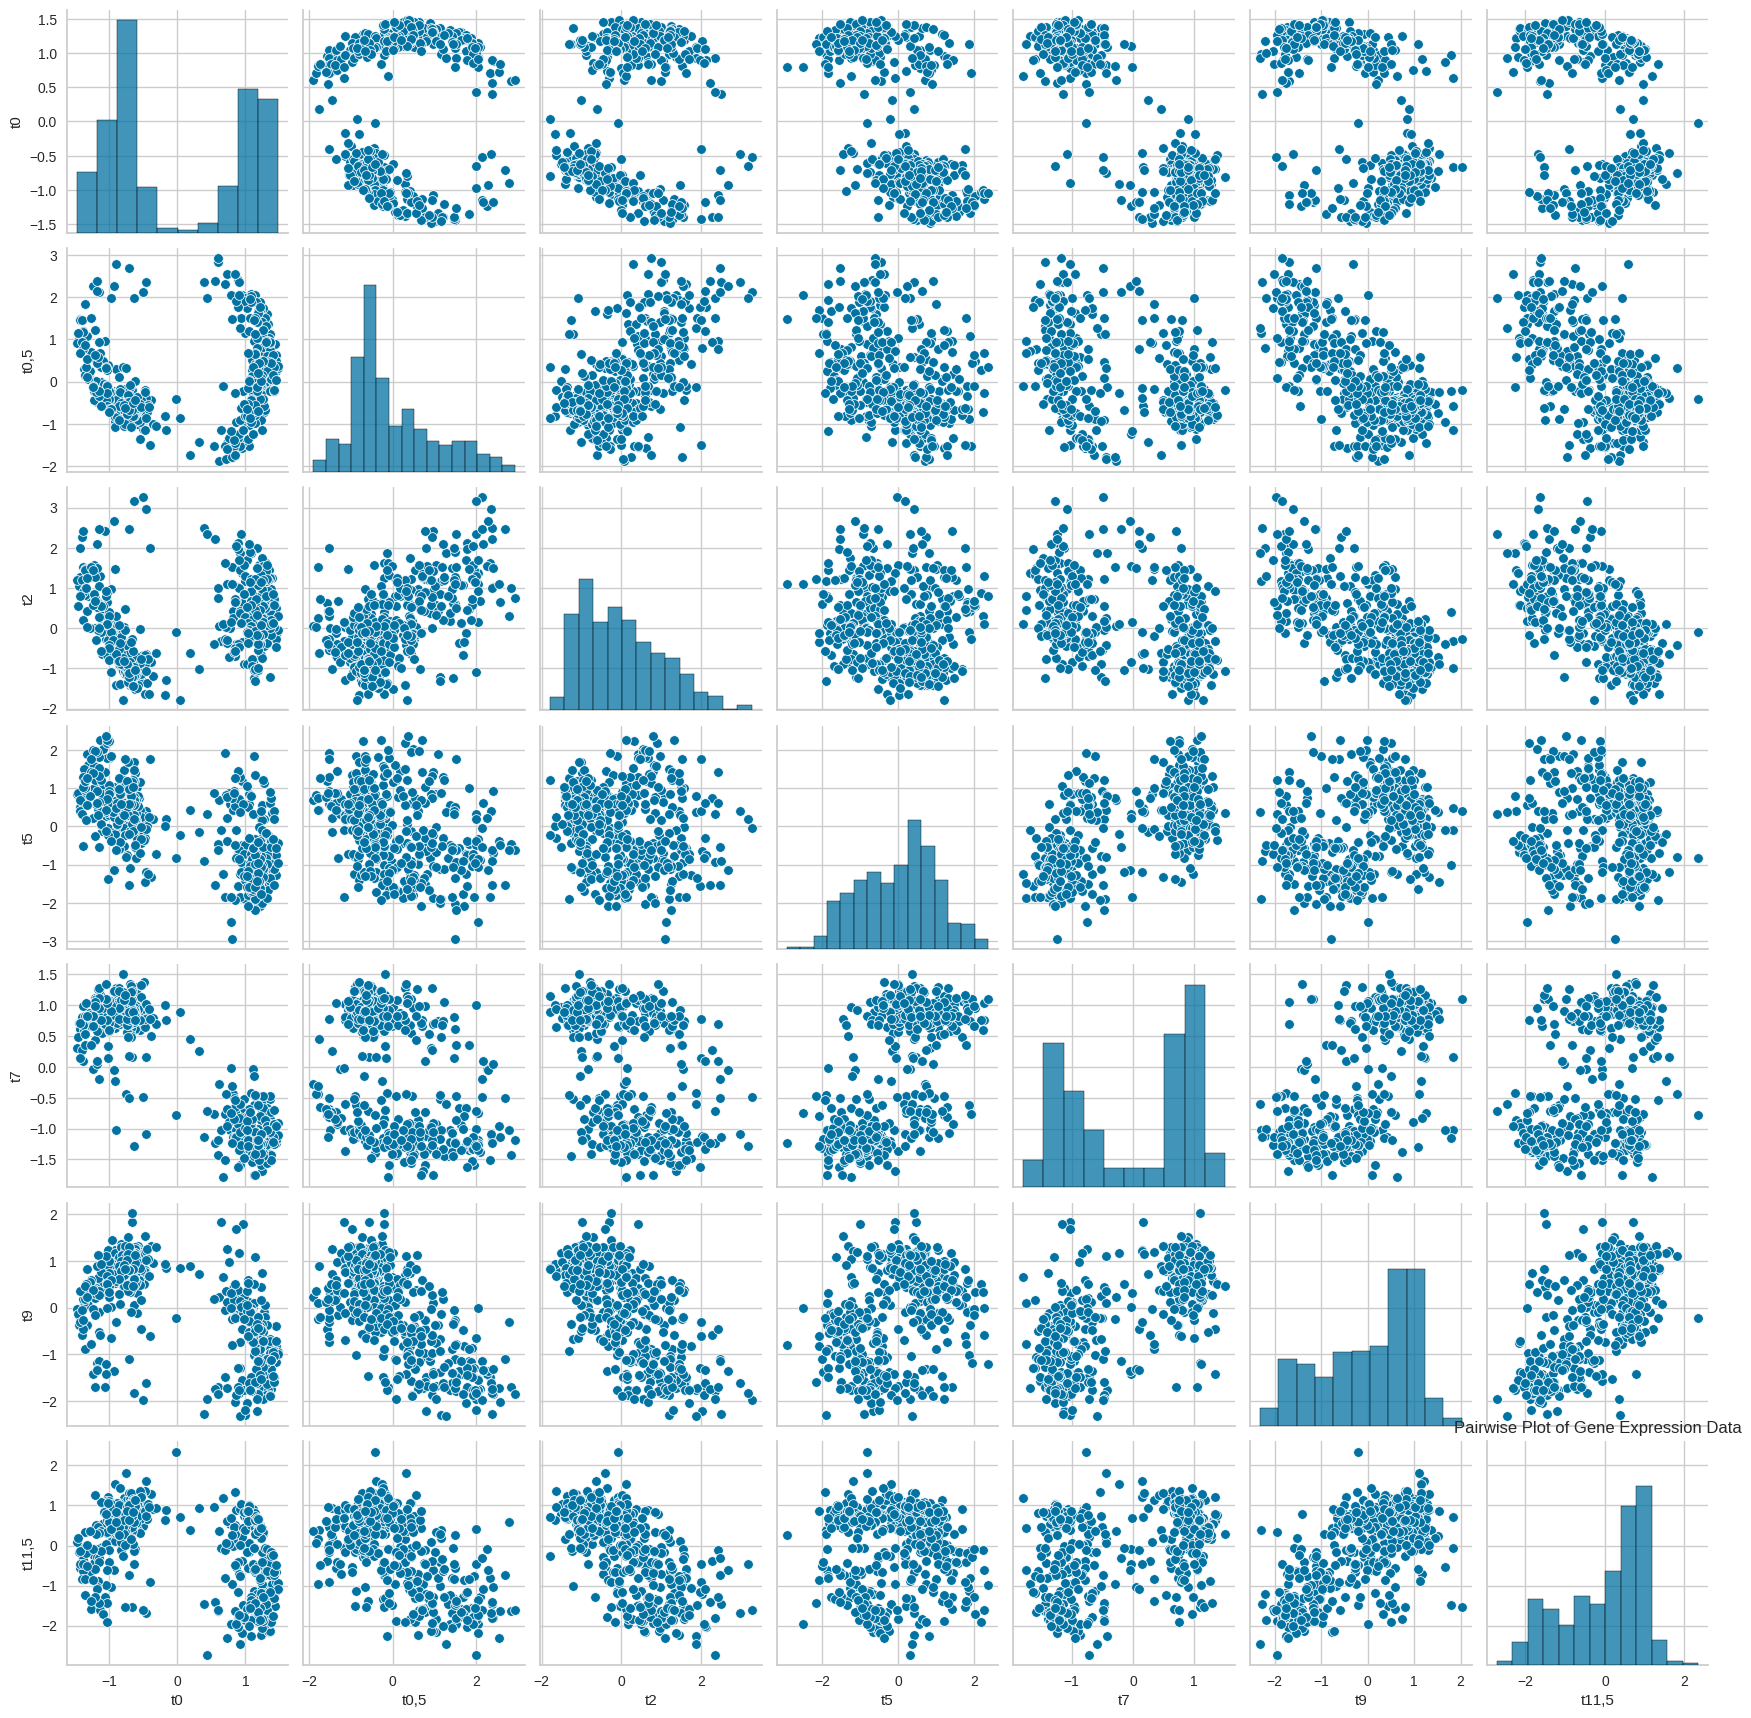

In [41]:
# Assuming 'scaled_data' is your DataFrame without the 'Genes' column
sns.pairplot(scaled_data)
plt.title("Pairwise Plot of Gene Expression Data")
plt.show()


 **Interpreting the Pair Plot:**
- **Diagonal Histograms**: On this occasion we can see how the standardization was a good success when seeing how clean the histograms look without anomalous points or an extremely wide distribution.

- **Scatter Plots**: The scatter plots displayed in the lower and upper triangles illustrate the relationships between pairs of features. Potential clusters may manifest as distinct groupings of points, which can suggest correlations or interactions between the variables.

- **Look for Patterns**: It can be observed that when relating the variables T0 with the other variables, they behave in a similar way. This may be due to the fact that T0 has a strong influence on the other variables or the existence of a hidden pattern. This will be interesting to see later.



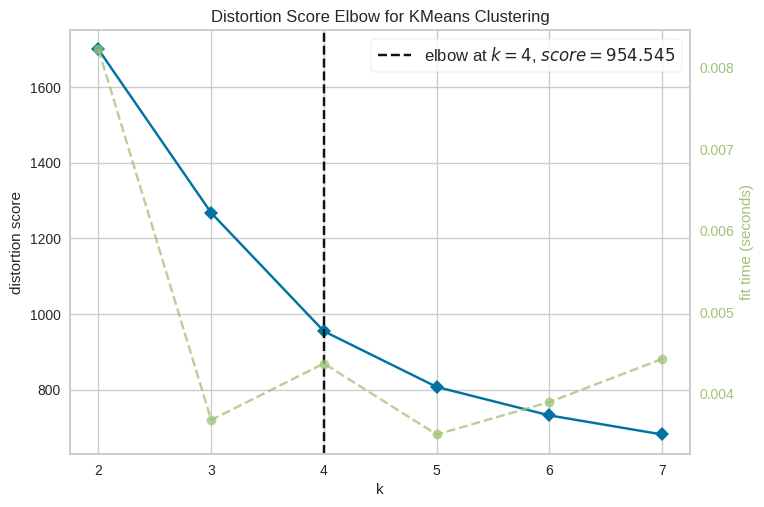

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [34]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Inicializamos el algoritmo KMeans
kmeans = KMeans()

# Creamos un visualizador para el método del codo
elbow_visualizer = KElbowVisualizer(kmeans, k=(2, 8))

# Ajustamos el visualizador a los datos escalados
elbow_visualizer.fit(scaled_data)

# Mostramos la gráfica del codo
elbow_visualizer.show()


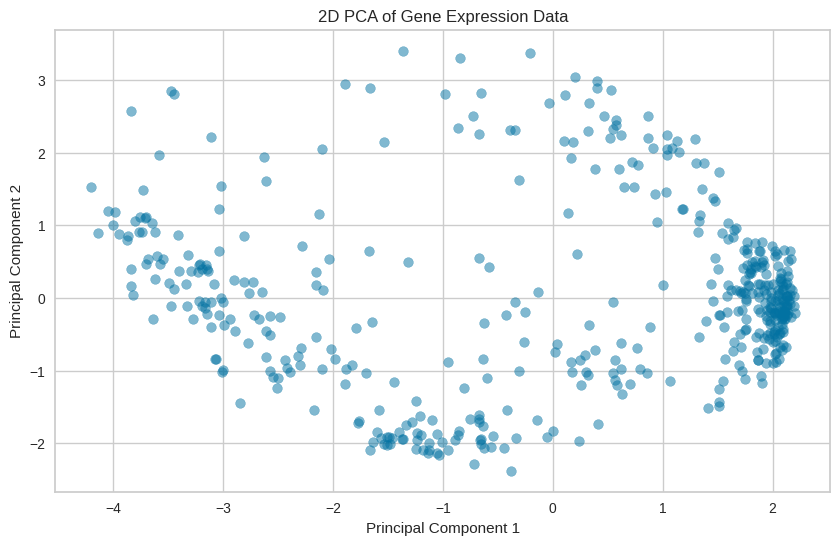

In [40]:
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)

# Create a DataFrame with the principal components
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.5)
plt.title('2D PCA of Gene Expression Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()
